In [3]:
from utils import import_data, compute_KNN_graph, create_graph, create_batch,reconstruct_symmetric_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_curve, auc


%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

#from numba import jit,prange

import time
import os

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
          'f1' : 'f1_macro',
          'roc_auc' : 'roc_auc'} 

In [157]:
df, phenotypic = import_data(fisher=True)
df = df.join(pd.DataFrame(phenotypic.Age), how='left')
df = df.join(pd.DataFrame(phenotypic['ADHD Measure']), how='left')
df = df.join(pd.DataFrame(phenotypic['Gender']), how='left')


df = ((df.reset_index()).drop(columns=['Institution', 'Subject'])).dropna(subset=[str(x) for x in range(0,17954)])
df = df.dropna(axis=0, subset=['Age'])
df = df.dropna(axis=0, subset=['Gender'])
df = df.dropna(axis=0, subset=['ADHD Measure'])

#df['ADHD Measure'] = df['ADHD Measure'].replace(np.nan, 0).astype(int)


#df = remove_collinear_features(df,0.8)

from sklearn.utils import shuffle
df = shuffle(df, random_state=42)



# Real test set
TEST =  df.iloc[-30:]

df = df.iloc[:-30]

# Labels
y = (df.Age).apply(lambda x: int(x))

# Remove from Fisher-space
X = np.tanh(df.iloc[:,:-3])
X_TEST =  np.tanh(TEST.iloc[:,:-3])
y_TEST =  (TEST.Age).apply(lambda x: int(x))

In [158]:
df.shape

(536, 17958)

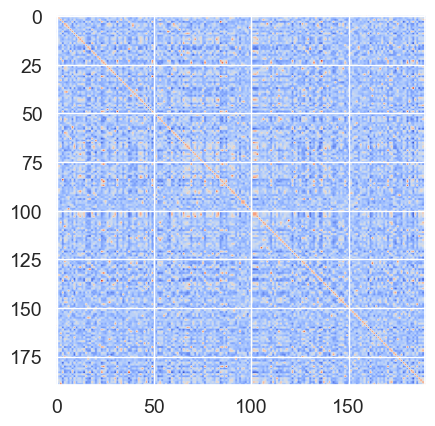

In [159]:
plt.imshow(reconstruct_symmetric_matrix(190,df.iloc[0,:-3]))

In [160]:
n = df.shape[0]

In [161]:
Matrix  = np.zeros((n, 190*190))

In [162]:
for i in range(0,n):
    Matrix[i,:] = reconstruct_symmetric_matrix(190,df.iloc[i,:-3]).ravel()

In [163]:
Matrix.shape

(536, 36100)

In [164]:
from sklearn.decomposition import PCA

# PCA
pca = PCA()

XPCA = pca.fit_transform(Matrix)

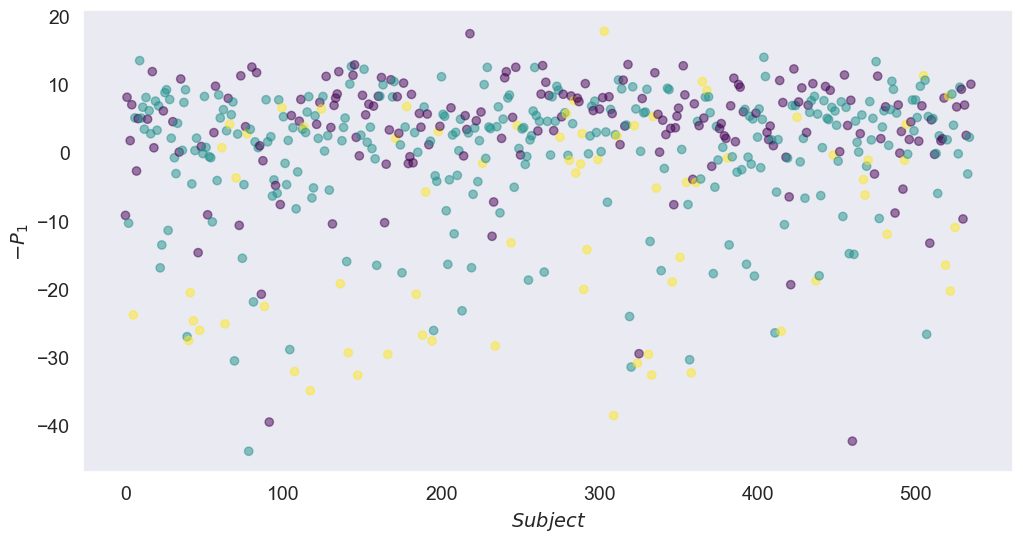

In [169]:

# Plot first and second principal component.

plt.figure(figsize=(12,6),dpi=100)

plt.scatter(np.arange(0,n),-XPCA[:,0],c=df['ADHD Measure'], cmap='viridis', alpha=0.5)#,c=Temps, cmap='viridis', alpha=0.5)#,edgecolors='black', linewidth=.5, s=50)
#plt.plot(np.arange(0,n),-XPCA[:,0],'.', color='darkcyan')
#plt.colorbar()
plt.ylabel(r'$-P_1$')
plt.xlabel(r'$Subject$')
#plt.yscale('log')
plt.grid()

plt.show()

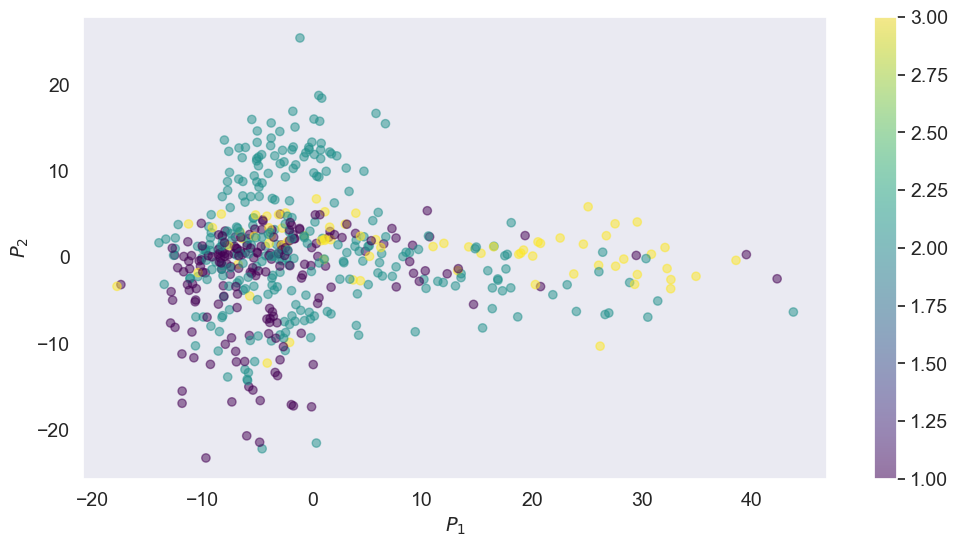

In [166]:

# Plot first and second principal component.

plt.figure(figsize=(12,6),dpi=100)

#plt.scatter(XPCA[:,0], XPCA[:,1],c=df['Gender'], cmap='viridis', alpha=0.5)#,edgecolors='black', linewidth=.5, s=50)
plt.scatter(XPCA[:,0], XPCA[:,1],c=df['ADHD Measure'], cmap='viridis', alpha=0.5)#,edgecolors='black', linewidth=.5, s=50)
#plt.scatter(XPCA[:,0], XPCA[:,1],c=df['Age'], cmap='viridis', alpha=0.5)#,edgecolors='black', linewidth=.5, s=50)

plt.colorbar()
plt.ylabel(r'$P_2$')
plt.xlabel(r'$P_1$')
plt.grid()

plt.show()

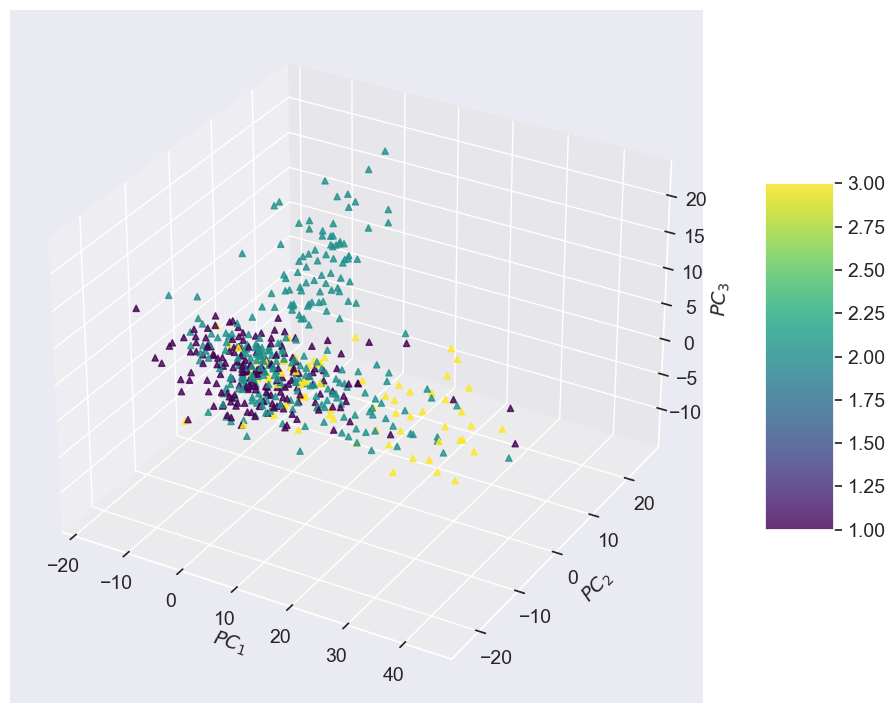

In [167]:
from mpl_toolkits import mplot3d
x = XPCA[:,0]
y = XPCA[:,1]
z = XPCA[:,2]

# Creating figure
fig = plt.figure(figsize = (16, 9), dpi=100)
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
 
# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = df['ADHD Measure'],
                    cmap = 'viridis',
                    marker ='^')

ax.set_xlabel(r'$PC_1$', fontweight ='bold')
ax.set_ylabel(r'$PC_2$', fontweight ='bold')
ax.set_zlabel(r'$PC_3$', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
# show plot
plt.show()

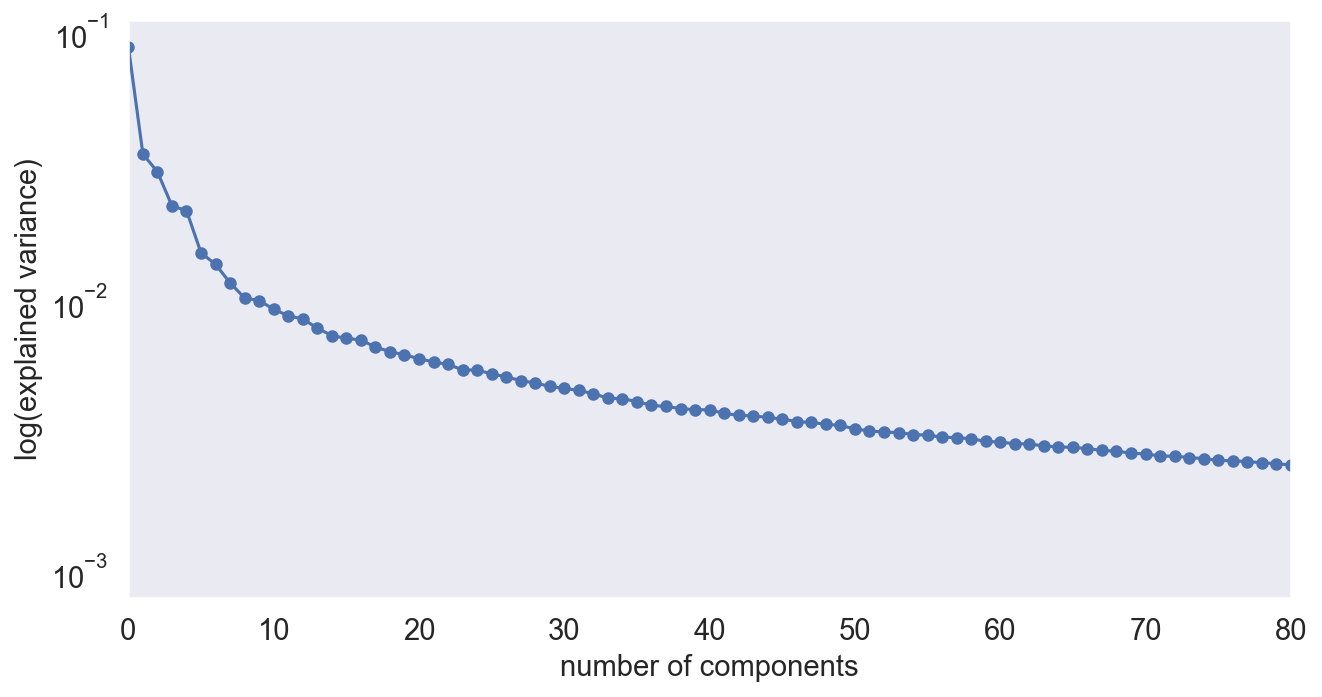

In [135]:
plt.figure(figsize=(10,5), dpi=150)
plt.plot(pca.explained_variance_ratio_[:-280], marker='.', markersize=10)
plt.xlabel(r'number of components')
plt.ylabel('log(explained variance)');
plt.yscale('log')
plt.xlim(0,80)
plt.grid()
plt.show()

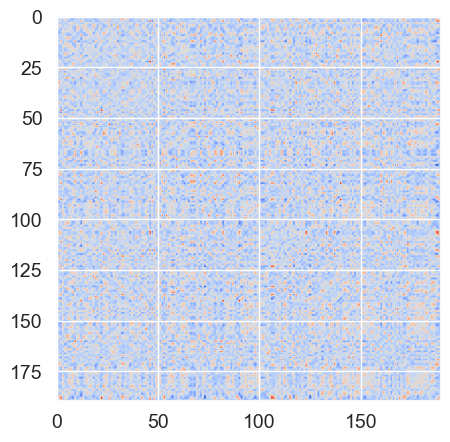

In [136]:
plt.figure(figsize=(5,5))
plt.imshow(pca.components_[0].reshape((190,190)))

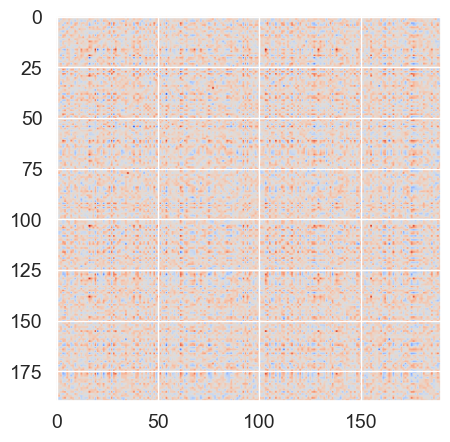

In [137]:
plt.figure(figsize=(5,5))
plt.imshow(pca.components_[1].reshape((190,190)))